# Goal
The goal of this notebook is to explore the correlation between new vulnerability discovery and a spike in open source software releases.

## Data
The `"release.csv"` dataset contains information pertaining to new software releases among open source software.
The NVD data sets contain information about vulnerabilities

##### Schema
The dataset contains the following columns:
`'id', 'target', 'date', 'date_offset', 'name', 'comment', 'author'`

Some fields relate to a handful of other datasets (directory info, snapshots, servers). The extra data is unnseccecary for our purposes.

## Challenges
##### Large Dataset
The full dataset is large (1.4 Gigs). A teaser dataset is being used to explore properties of the data.
##### Unclear Connection
We wish to compare this dataset with another set, NVD, which contains information about discovered software vulnerabilities.
It may be possible to directly relate and connect the two datasets. This requires exploring of the two sets.

Alternatively, we can always correlate the two.





## Project Review 2

Explore the correlation between vulnerability publish and spike in frequency.


# Code
Simple imports

Declaring column headers and path to the data (on my machine)

In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = [16,9]

# Releases

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
revision_header = ['id', 'date', 'committer_date', 'directory', 'message', 'author', 'committer']
release_path = 'D:/data/open_source/release.csv'

Some fields are stored as hexidecimal strings, this function converts it to decimal.

Also, a function to convert the incoming date string to a dateitme object.

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

The data is read in and only the useful columns are kept

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

This function allows resample of the releases

In [5]:
def releases_resample(resample_by):
    return (release_df[['date','id']].set_index('date').resample( resample_by ).count()).rename(columns={'id':'count'})

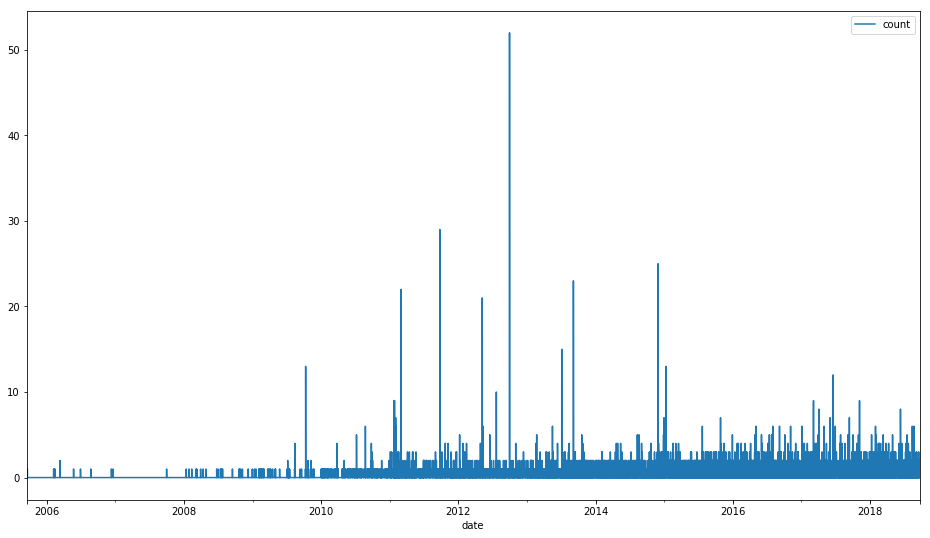

In [26]:
r_h = releases_resample('H')
r_h.plot()

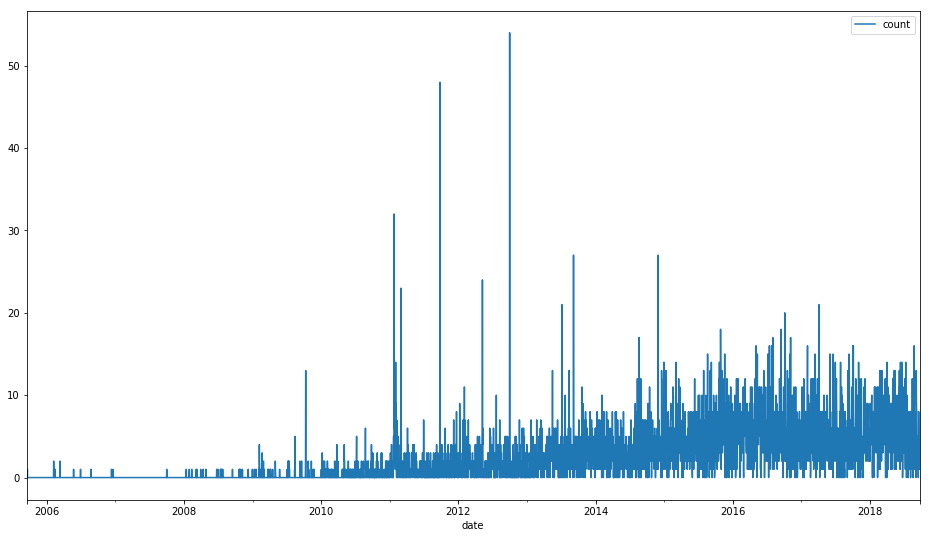

In [27]:
r_d = releases_resample('d')
r_d.plot()

In [8]:
r_d.head()

,count
date,
2005-09-16,1
2005-09-17,0
2005-09-18,0
2005-09-19,1
2005-09-20,0


Here we see spikes in the data. This may be erreoneous data.

It is possible that these spikes in `dayly` release rate is due to a response to an extreme vulnerability. This could also be due to various other factors, such as github/others servers crashing, and only pushing releases after coming back online.

# National Vulnerability Dataset

In [9]:
def date_str_nvd(st):
    return pd.to_datetime( st, format='%Y-%m-%dT%H:%MZ')

def score_nvd(json):
    if json['impact'] and 'baseMetricV2' in json['impact']:
        return json['impact']['baseMetricV2']['cvssV2']['baseScore']
    else:
        return 0.0

Gather all NVD Datasets into one dataframe

In [10]:
def import_nvd(nvd_start=2, nvd_end=19):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = 'D:/data/open_source/NVD/nvdcve-1.1-'+year+'.json.zip'
        if i==nvd_start:
            nvd = pd.read_json(path, encoding="utf8")
        else:
            nvd = nvd.append( pd.read_json(path, encoding="utf8") )
    return nvd.reset_index()

def import_nvd_clean(nvd_start=2, nvd_end=20):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = 'D:/data/open_source/NVD/nvdcve-1.1-'+year+'.json.zip'
        if i==nvd_start:
            nvd = clean_nvd(pd.read_json(path, encoding="utf8"))
        else:
            nvd = nvd.append( clean_nvd(pd.read_json(path, encoding="utf8")) )
    nvd = nvd.reset_index()
    nvd = nvd.drop(['index'], 1)
    return nvd


def clean_nvd(nvd):
    nvd['date'] = nvd['CVE_Items'].apply( lambda x: date_str_nvd(x['publishedDate']) )
    nvd['score'] = nvd['CVE_Items'].apply( lambda x: score_nvd(x) )
    new_nvd = nvd.drop(['CVE_data_type','CVE_data_format','CVE_data_version','CVE_data_numberOfCVEs','CVE_data_timestamp','CVE_Items'], 1)
    return new_nvd

`nvd` contains all NVD Vulnerability information
Not much of it is needed, and takes a lot of memory.

In [11]:
#nvd = import_nvd(15,16)

In [12]:
#nvd.head()

Nearly all useful information (date and score) is held within the JSON object in the `CVE_Items` tab.

In [13]:
#nvd['CVE_Items'][1]

All vulnerabilities within NVD have a published date accessible by

In [14]:
#nvd['CVE_Items'][1]['publishedDate']

Along with a vulnerability score, accessible by

In [15]:
#nvd['CVE_Items'][1]['impact']['baseMetricV2']['cvssV2']['baseScore']

Some (around 10% of) vulnerabilities have no vulnerability information. They are given a score of 0.0 (for now)

In [16]:
#nvd['CVE_Items'][25]#['impact']['baseMetricV2']['cvssV2']['baseScore']

`clean_nvd` imports NVD, but only keeps the important columns.
`date` (date vulnerability was published) and `score` (A measure of the severity and impact of the vulnerability 0.0-10.0). Most all other columns are removed, as they are not needed.

In [17]:
nvd_clean = import_nvd_clean()

In [18]:
nvd_clean.head()

,date,score
0,1999-12-30 05:00:00,5.0
1,1998-10-12 04:00:00,10.0
2,1998-04-01 05:00:00,10.0
3,1997-12-16 05:00:00,5.0
4,1998-07-20 04:00:00,10.0


Number of vulnerabilities given score of 0.0 since they had no vulnerability information

In [19]:
nvd_clean[ nvd_clean.score == 0.0].shape[0]

7127

In [20]:
def vulnerability_resample(resample_by):
    return (nvd_clean[['date','score']].set_index('date').resample(resample_by).count()).rename(columns={'score':'count'})

In [21]:
v_h = vulnerability_resample('h')
v_d = vulnerability_resample('d')

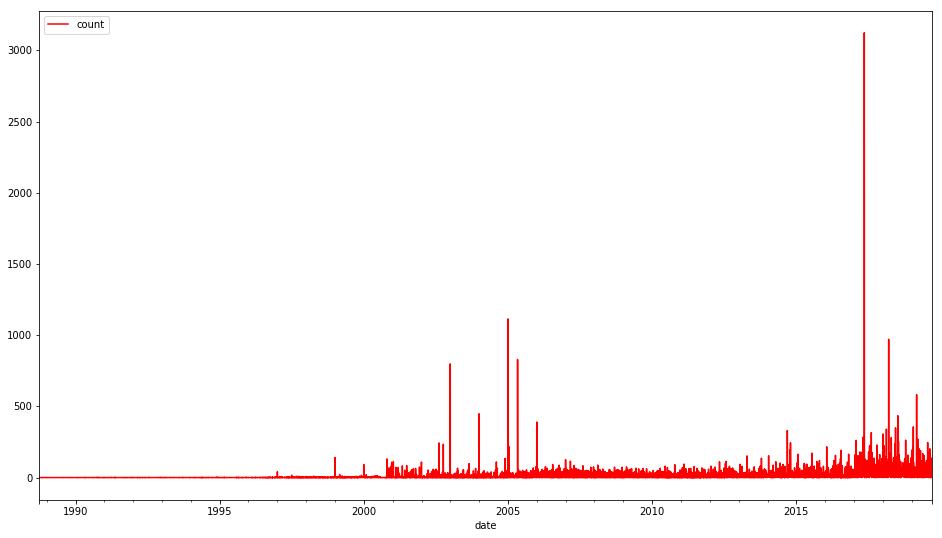

In [28]:
v_d.plot(color="red")

# Correlation Between Release and NVD

We next explore if there is a correlation between vulnerability publish date and spike in frequency

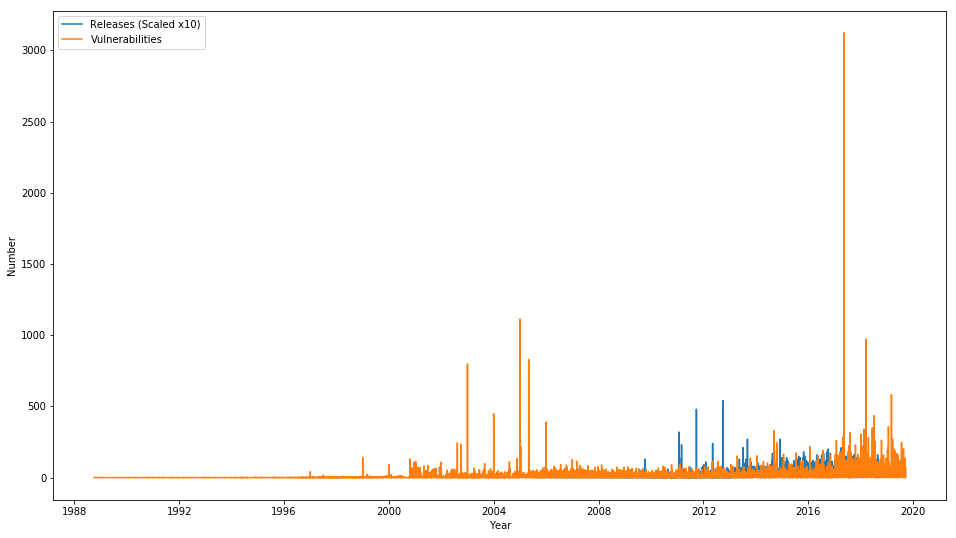

In [29]:
plt.plot(r_d*10, label="Releases (Scaled x10)")
plt.plot(v_d, label="Vulnerabilities")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

Correlation between NVD and releases

In [24]:
#r_h['date'].corr(v_h['date'])